In [211]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [55]:
# loading the dataset
boston = pd.read_csv('Boston\listings.csv')

In [71]:
# The columns the dataset
boston.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [76]:
# shape of the dataset
boston.shape

(3585, 95)

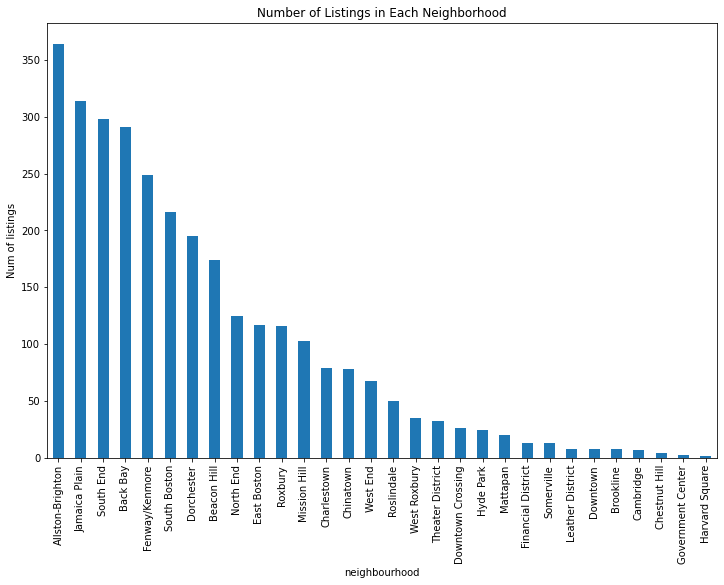

In [250]:
# Count the number of listings of each neighborhood
boston_nb = boston.groupby('neighbourhood').count().sort_values('id',ascending= False)
plot = boston_nb.plot(kind = 'bar', y= 'id',figsize=(12,8),legend = False)
plt.title('Number of Listings in Each Neighborhood')
plt.ylabel('Num of listings')
plt.show();
fig = plot.get_figure()
fig.savefig('Illustrations/numlisting.png');

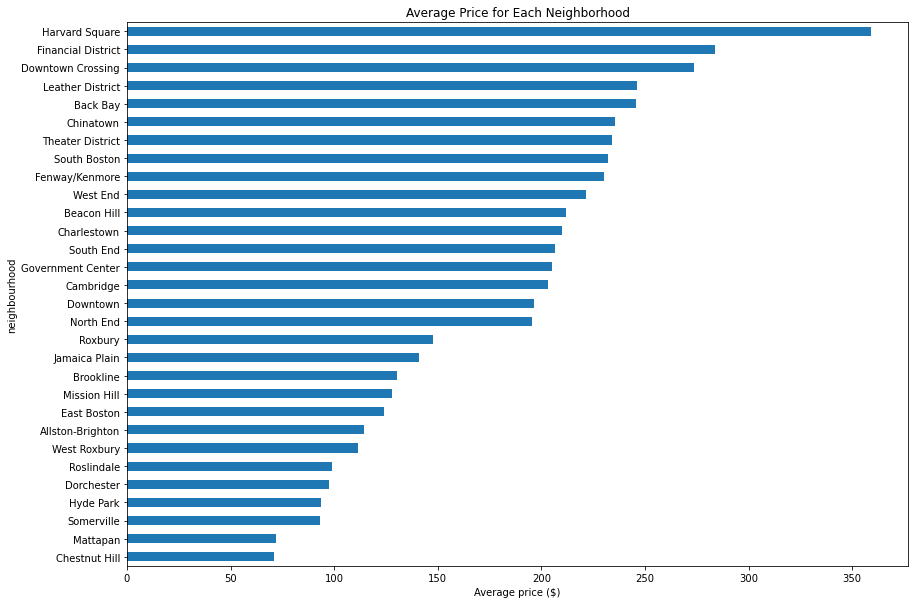

In [254]:
# Count the average price of the listings of each neighborhood after data cleaning
boston['price'] = boston['price'].replace('[\$,]', '', regex=True).astype(float)
boston_nb = boston.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
plot = boston_nb.plot(kind='barh',figsize=(14,10))
plt.title('Average Price for Each Neighborhood')
plt.xlabel('Average price ($)')
plt.show();
fig = plot.get_figure()
fig.savefig('Illustrations/avgprice.png');

In [95]:
# obtaining the average review ratings of each neighborhood
boston.dropna(subset=['review_scores_rating']).groupby('neighbourhood')['review_scores_rating'].mean()

neighbourhood
Allston-Brighton       90.067164
Back Bay               91.531818
Beacon Hill            93.811688
Brookline             100.000000
Cambridge              74.500000
Charlestown            94.147541
Chestnut Hill          90.000000
Chinatown              92.377778
Dorchester             89.579882
Downtown               83.285714
Downtown Crossing      91.380952
East Boston            89.745283
Fenway/Kenmore         89.349693
Financial District     98.250000
Government Center      92.000000
Hyde Park              93.611111
Jamaica Plain          94.427509
Leather District       98.400000
Mattapan               88.500000
Mission Hill           87.550725
North End              93.962617
Roslindale             95.565217
Roxbury                90.833333
Somerville             88.571429
South Boston           94.365169
South End              93.145161
Theater District       89.363636
West End               92.054054
West Roxbury           96.407407
Name: review_scores_rating, d

In [138]:
# dummy variable of each category
neighbour = pd.get_dummies(boston['neighbourhood'])

In [139]:
property_type = pd.get_dummies(boston['property_type'])

In [140]:
# cleaning the data
boston['host_is_superhost'] = boston['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)

In [143]:
# getting the desired features
features = ['beds','bathrooms','bedrooms','host_is_superhost']
X = boston[features]

In [144]:
X

,beds,bathrooms,bedrooms,host_is_superhost
0,3.0,1.5,2.0,0
1,1.0,1.0,1.0,0
2,1.0,1.0,1.0,0
3,2.0,1.0,1.0,0
4,2.0,1.5,1.0,0
...,...,...,...,...
3580,1.0,1.0,1.0,0
3581,1.0,1.0,1.0,0
3582,1.0,1.0,1.0,0
3583,1.0,1.0,1.0,0


In [145]:
# Merging the df with the dummy variables
X = pd.concat([X, property_type, neighbour],axis=1)

In [155]:
# fill NaN values with the mean of the column
X.fillna(X.mean(),inplace=True)

In [158]:
# setting the price as our label
y = boston['price']

In [160]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [170]:
# initalizing pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('lasso', linear_model.Lasso())])

In [238]:
# setting up gridsearch
param = {
    'lasso__alpha': [0,0.01,0.1,1]
}
pipecv = GridSearchCV(pipeline, param, n_jobs=-1, refit=True, scoring='r2')
pipecv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1, param_grid={'lasso__alpha': [0, 0.01, 0.1, 1]},
             scoring='r2')

In [239]:
# best score during CV
pipecv.best_score_

0.35121604089987585

In [240]:
# getting coefficients of the model
coefficients = pipecv.best_estimator_['lasso'].coef_

In [241]:
# predicting the test subset
y_pred = pipecv.predict(X_test)

In [187]:
# MSE score
mean_squared_error(y_test, y_pred)

28131.0221229554

In [242]:
# r2 score
r2_score(y_test, y_pred)

0.19257311533211197

In [222]:
# setting up a df for visualization
coefs = pd.DataFrame(columns = X.columns)

In [224]:
coefs.loc[0] = coefficients

In [228]:
coefs.sort_values(by = 0, axis=1,inplace=True)

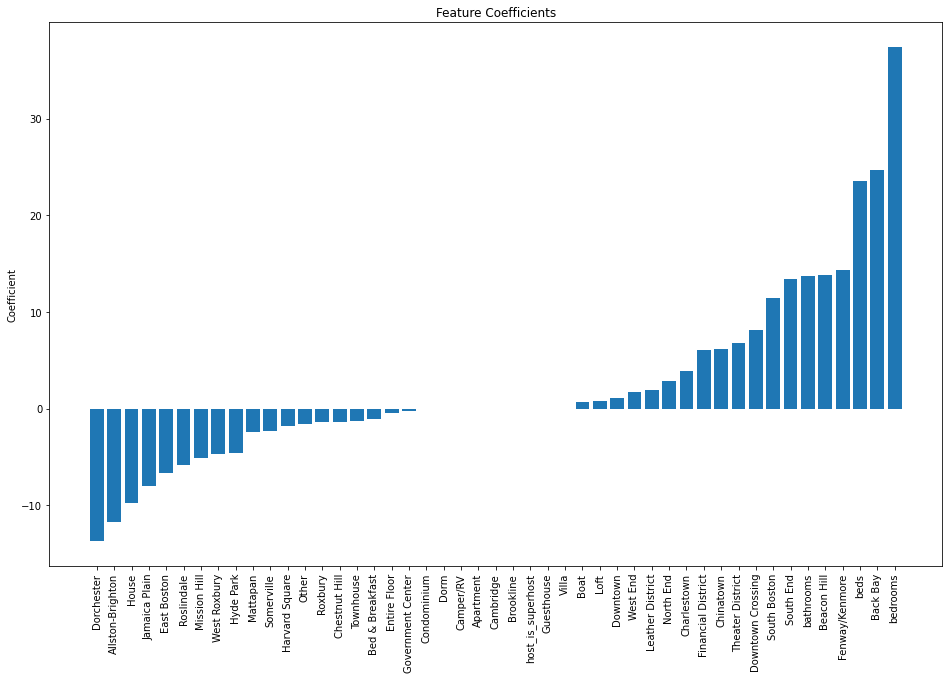

In [253]:
fig = plt.figure(figsize=(16,10))
plt.bar(coefs.columns, coefs.loc[0])
plt.xticks(rotation=90)
plt.title('Feature Coefficients')
plt.ylabel('Coefficient')
plt.show();
fig.savefig('Illustrations/coef.png');